# Mitigating Bias in ML with SHAP and Fairlearn

Model explainability and fairness are rightfully hot topics today. Models learn about an imperfect world through imperfect data, and practitioners can unintentionally encode and learn to repeat those imperfections in machine learning models. Much attention is given to _detecting_ "biased models", but perhaps less to _how to mitigate_ the problem, and in fact the modeling process can be part of the solution, rather than a source of the problem.

This notebook considers the problem of predicting recidivism -- will an individual arrested for a crime be arrested again? ProPublica considered the problems of predicting recidivism when they [analyzed a tool called COMPAS](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm) that is used for this purpose. They obtained and analyzed information on 11,757 defendants in Broward Country, Florida. They found differences in how, for example, African-Americans are scored. Whether these differences are 'unfair' is less clear, as described by [this response](https://medium.com/@AbeGong/ethics-for-powerful-algorithms-1-of-3-a060054efd84).

Rather than analyze COMPAS, this notebook builds a model from scratch, evaluates what 'fair' can mean, and looks at the effect of various strategies for mitigating unfairness:

1. Do nothing!
1. Avoid using sensitive information like demographics as the model input
1. Post-process the model to 'force' more fairness with [Microsoft's Fairlearn](https://github.com/fairlearn/fairlearn)
1. Isolate and reverse the direct effect of sensitive information with SHAP

## Data Preparation

This notebook uses ProPublica's [cleaned-up version of raw COMPAS data](https://github.com/propublica/compas-analysis/blob/master/compas.db), specifically the `people` table. This table is just exported as a CSV file and uploaded to a location on DBFS. To export:

```
sqlite3 compas.db

sqlite> .mode csv
sqlite> .headers on
sqlite> .once compas.csv
sqlite> SELECT * FROM people;
```

This contains most of the relevant inputs about persons in the study, as well as whether they recidivate. For the relatively simple purposes of this example, a simple subset of the data is selected along with some lightly-engineered features -- for example:

- `age` is used but not its bucketing in `age_cat`
- the charge type is broken down by class and degree
- name is not used
- time to recidivism and censoring effects are ignored

These choices are debatable, but result in an moderately-accurate and understandable model to analyze as an example.

In [ ]:
compas_df = spark.read.option("header", True).option("inferSchema", True).csv("/home/user@databricks.com/compas.csv")
display(compas_df)

In [ ]:
from pyspark.sql.functions import col, datediff, udf
import pandas as pd
import numpy as np

# Extracts charge type like "M" from a string like "M1" (misdemeanor 1)
@udf(returnType='string') 
def charge_type(c_charge_degree):
  class_letter = c_charge_degree[1]
  return class_letter if class_letter == 'M' or class_letter == 'F' else 'Other'    

# Extracts charge degree like 1 from "M1"
@udf(returnType='int') 
def charge_class(c_charge_degree):
  class_letter = c_charge_degree[1]
  return int(c_charge_degree[-2]) if class_letter == 'M' or class_letter == 'F' else 0

# Some preemptive feature eng - use jail time, not absolute in/out time; drop those without a charge degree; parse out charge type/degree
compas_cleaned_df = compas_df.\
  select("sex", "race", "age", "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", "c_jail_in", "c_jail_out", "c_charge_degree", "is_recid").\
  withColumn("c_jail_time", datediff("c_jail_out", "c_jail_in")).fillna(0, subset="c_jail_time").drop("c_jail_in", "c_jail_out").\
  dropna(how="any", subset="c_charge_degree").\
  withColumn("c_charge_type", charge_type("c_charge_degree")).\
  withColumn("c_charge_class", charge_class("c_charge_degree")).\
  drop("c_charge_degree").\
  filter(col("is_recid") >= 0)

# One hot encoding of categoricals - makes this easier to reason about with SHAP
# Could be done with Spark! just simpler to write in pandas
compas_pd = pd.get_dummies(compas_cleaned_df.toPandas(), dtype=np.int32).drop(["sex_Female", "race_Other", "c_charge_type_Other"], axis=1)
compas_pd.columns = [c.replace("-", "_").replace(" ", "_") for c in compas_pd.columns] # Massage away problem chars in col name
compas_cleaned_df = spark.createDataFrame(compas_pd)

# You're welcome to change the database name!
# spark.sql("DROP TABLE IF EXISTS user.compas")
# compas_cleaned_df.write.saveAsTable("user.compas")

compas_cleaned_df.toPandas()

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,is_recid,c_jail_time,c_charge_class,sex_Male,race_African_American,race_Asian,race_Caucasian,race_Hispanic,race_Native_American,c_charge_type_F,c_charge_type_M
0,69,0,0,0,0,0,1,3,1,0,0,0,0,0,1,0
1,34,0,0,0,0,1,10,3,1,1,0,0,0,0,1,0
2,24,0,0,1,4,1,1,3,1,1,0,0,0,0,1,0
3,23,0,1,0,1,0,0,3,1,1,0,0,0,0,1,0
4,43,0,0,0,2,0,0,7,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11009,47,0,0,0,1,0,1,3,1,0,0,0,0,0,1,0
11010,22,0,3,5,3,1,2,1,1,0,0,1,0,0,0,1
11011,35,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1
11012,29,0,0,0,2,0,1,1,1,0,0,1,0,0,0,1


## Establishing a Baseline Model

Before discussing whether a model is 'fair', there has to be a model! Running Auto ML on this dataset suggests that xgboost works well on this data set, so a simple xgboost model is tuned and trained with hyperopt and xgboost, and logged with MLflow.

In [ ]:
%pip install fairlearn>=0.7.0

Python interpreter will be restarted.
Python interpreter will be restarted.


In [ ]:
from sklearn.model_selection import train_test_split

compas_table = spark.read.table("user.compas")
X = compas_table.drop("is_recid").toPandas()
y = compas_table.select("is_recid").toPandas()['is_recid'] # makes this a Series
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=0)
drop_cols = [c for c in X_train.columns if c.startswith("sex") or c.startswith("race")]

Set up some utility methods to run hyperopt tuning of an xgboost model, making it easy to drop in different model fitting processes with `predict_fn`:

In [ ]:
from hyperopt import fmin, hp, tpe, SparkTrials, STATUS_OK
import mlflow
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, recall_score
from xgboost import XGBClassifier

# Function that actually fits a model and returns its predictions, so we can swap it out later:
def predict_xgboost(X_train_xgb, y_train_xgb, X_val_xgb, y_val_xgb, params):
    mlflow.xgboost.autolog(disable=False, log_models=True)
    # Balance the positive/negative classes evenly via weighting
    pos_weight = (len(y_train_xgb) / y_train_xgb.sum().item()) - 1
    model = XGBClassifier(use_label_encoder=False, n_jobs=4, n_estimators=2000, random_state=0, scale_pos_weight=pos_weight,
                          max_depth=int(params['max_depth']), learning_rate=params['learning_rate'], min_child_weight=params['min_child_weight'],
                          subsample=params['subsample'], colsample_bytree=params['colsample_bytree'])
    # n_estimators is high above, but, early stopping should stop long before that maximum!
    model.fit(X_train_xgb, y_train_xgb, eval_set=[(X_val_xgb, y_val_xgb)], eval_metric="logloss", early_stopping_rounds=10)
    return model.predict(X_val_xgb)

def run_data_experiment(data_experiment_tag, drop_cols=[], predict_fn=predict_xgboost):
    def train_model(params):
        mlflow.set_tag("data_experiment", data_experiment_tag)
        y_pred = predict_fn(X_train.drop(drop_cols, axis=1), y_train, X_val.drop(drop_cols, axis=1), y_val, params)
        f1 = f1_score(y_val, y_pred)
        mlflow.log_metrics({ 'accuracy': accuracy_score(y_val, y_pred), 'f1_score': f1, 'recall': recall_score(y_val, y_pred) })
        return { 'status': STATUS_OK, 'loss': -f1 }
    
    search_space = {
      'max_depth':        hp.quniform('max_depth', 2, 10, 1),
      'learning_rate':    hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),
      'min_child_weight': hp.qloguniform('min_child_weight', np.log(1), np.log(10), 1),
      'subsample':        hp.uniform('subsample', 0.5, 1),
      'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)
    }
  
    fmin(fn=train_model, space=search_space, algo=tpe.suggest, max_evals=128, trials=SparkTrials(parallelism=12))

Actually run the first baseline model experiment!

In [ ]:
run_data_experiment("with_demographics")

Hyperopt with SparkTrials will automatically track trials in MLflow. To view the MLflow experiment associated with the notebook, click the 'Runs' icon in the notebook context bar on the upper right. There, you can view all runs.
To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.
100%|██████████| 128/128 [12:07<00:00,  5.68s/trial, best loss: -0.5892116182572613]
Total Trials: 128: 128 succeeded, 0 failed, 0 cancelled.


And some utility methods that will help analyze the result:

In [ ]:
from fairlearn.metrics import MetricFrame, false_positive_rate, false_negative_rate, selection_rate
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
from pyspark.sql.functions import col, when
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, ConfusionMatrixDisplay

# Finds the run in an experiment with a given tag and the highest F1 score
def find_best_run_id(data_experiment_tag):
    # TODO: change to your notebook's experiment ID, or path to experiment you use:
    return spark.read.format("mlflow-experiment").load("909eb80898e946bab8fed8938af419c0").\
       filter(col("tags.data_experiment") == data_experiment_tag).\
       orderBy(col("metrics.f1_score").desc()).\
       select("run_id").take(1)[0]['run_id']

# Finds the best run for a tag per above, runs the model on validation data and returns results
def get_recid_data(data_experiment_tag, drop_cols=[]):
    run_id = find_best_run_id(data_experiment_tag)
    recid_model = mlflow.pyfunc.load_model(f"runs:/{run_id}/model")
    recid_df = pd.concat([X_val, y_val], axis=1).reset_index(drop=True)
    recid_df["prediction"] = recid_model.predict(X_val.drop(drop_cols, axis=1)).astype('int32')
    return recid_df

# Utility method to find best model by tag per above, run predictions, compute two confusion matrices by
# race and show them along with their difference
def show_confusion_matrix_diff(data_experiment_tag, drop_cols=[], race="African_American"):
    recid_df = get_recid_data(data_experiment_tag, drop_cols)
    def get_cm(label):
        data_pd = recid_df[recid_df[f"race_{race}"] == label][["is_recid", "prediction"]]
        return confusion_matrix(data_pd['is_recid'], data_pd['prediction'], normalize='all')
  
    not_race_cm = get_cm(0)
    race_cm = get_cm(1)
  
    _, axes = plt.subplots(1, 3, figsize=(20,5), sharey='row')
    plt.rcParams.update({'font.size': 16})
    labels = ["Not Recid", "Recid"]
    ConfusionMatrixDisplay(not_race_cm, display_labels=labels).plot(ax=axes[0], cmap='Blues', colorbar=False).\
      ax_.set_title(f"Not race_{race}")
    ConfusionMatrixDisplay(race_cm, display_labels=labels).plot(ax=axes[1], cmap='Blues', colorbar=False).\
      ax_.set_title(f"race_{race}")
    ConfusionMatrixDisplay(race_cm - not_race_cm, display_labels=labels).plot(ax=axes[2], cmap='Purples', colorbar=False).\
      ax_.set_title("Difference") 
    plt.show()

# Loads the best model for a tag per above, computes predictions and evaluates fairness metrics.
# Logs them back to MLflow and returns the result for display
def show_fairness_metrics(data_experiment_tag, drop_cols=[]):
    recid_df = get_recid_data(data_experiment_tag, drop_cols)
    metrics = {
      "accuracy": accuracy_score,
      "recall": recall_score,
      "false positive rate": false_positive_rate,
      "false negative rate": false_negative_rate,
      "selection rate": selection_rate
    }
    mf = MetricFrame(metrics=metrics, y_true=y_val, y_pred=recid_df["prediction"], \
                     sensitive_features=X_val["race_African_American"], control_features=y_val).by_group
    # Update the run with new metrics
    (fpr_not_af_am, fpr_af_am, _, _) = mf['false positive rate']
    (_, _, fnr_not_af_am, fnr_af_am) = mf['false negative rate']
    run_id = find_best_run_id(data_experiment_tag)
    with mlflow.start_run(run_id=run_id):
        mlflow.log_metrics({
          "Not Af-Am FPR": fpr_not_af_am,
          "Af-Am FPR": fpr_af_am,
          "Not Af-Am FNR": fnr_not_af_am,
          "Af-Am FNR": fnr_af_am
        })
    return mf

## 1. Do nothing

### What is Fair?

What does 'fair' mean? to whom and in what way? Of course, we are often concerned with fairness to people, and whether model results systematically favor or disfavor a demographic group. It is unfortunately true that the US justice system has ultimately treated African-American defendants more harshly than white defendants, as hinted at in the ProPublica analysis even in this very example. This will be the question: is this model 'fair' to African-American defendants? This is of course not the only possible or important question to consider, but an obvious one to choose to study.

One might suppose that a 'fair' model is one that is blind to sensitive inputs, one that does not learn directly from attributes like race. This is a plausible but narrow definition of fairness, but likely insufficient in cases like this.

More strongly, one might say the model is fair if treats this group "the same" as other people, that there is some equality of outcome regardless of inputs, but this needs precision. For example, a model that returned the same result for every input would certainly be fair in this sense! It would also be useless.

Instead, fairness is usually measured in terms of common metrics like recall (true positive rate) or false positive rate for classifiers. See [Equality of Opportunity in Supervised Learning
](https://arxiv.org/abs/1610.02413) (Hardt, Price, Srebro) for a thorough discussion. The question is not whether these metrics differ, in this case, for defendants of different races overall. Fairness criteria in the case of a binary classifier instead examine the difference across groups, separately, for those whose true label is positive vs negative. That is, in this case, the question is whether _among recidivists_, the model treats African-American defendants differently, and likewise for _non-recidivisits_.

This is what the confusion matrix and the fairness metrics look like with the baseline model, which does not make any adjustments to mitigate disparate impacts:

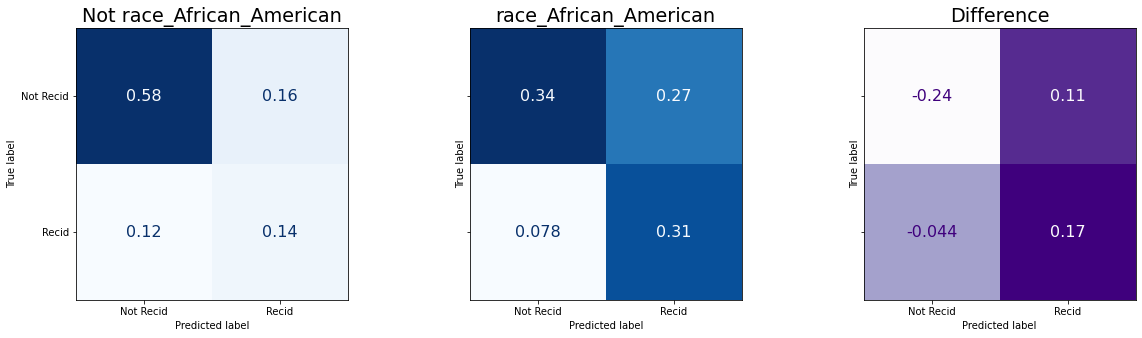

In [ ]:
show_confusion_matrix_diff("with_demographics")

In [ ]:
show_fairness_metrics("with_demographics")

/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy 
 recall 
 false positive rate 
 false negative rate 
 selection rate 
 
 
 is_recid 
 race_African_American 
 
 
 
 
 
 
 
 
 
 0 
 0 
 0.786335 
 0.0 
 0.213665 
 0.0 
 0.213665 
 
 
 1 
 0.558824 
 0.0 
 0.441176 
 0.0 
 0.441176 
 
 
 1 
 0 
 0.533101 
 0.533101 
 0.0 
 0.466899 
 0.533101 
 
 
 1 
 0.798144 
 0.798144 
 0.0 
 0.201856 
 0.798144

The two confusion matrices in blue show the model's treatment of recidivists vs non-recidivists, for African-American defendants vs the rest of the population. One thing jumps out: the model is generally more likely to classify a defendant as recidivist (the right column compared to left column, of each confusion matrix) when African-American. That sounds unfair. It holds up when looking only at actual recidivists (top rows) or non-recidivisits (bottom rows). The differences are in purple at the right. African-American defendants who did not recidivate are predicted to do so at a rate 11% higher than others. For those that did recidivate, the difference is 17%.

Several additional metrics are computed here, from which it's clear that, overall, recall (true positive rate) and false positive rate are substantially different -- higher -- for African-Americans. They are about 26% and 23% higher respectively. This fails to achieve "equalized odds", a popular choice among many definitions of metric-based fairness, which would require that these rates be the nearly identical for any subgroup, for both the recidivist and non-recidivist groups, separately. This isn't the only possible metric to try to equalize, but most fairness measures will be concerned with equal treatment across subgroups _conditional on_ the true label.

This does not, in particular, require that the model's fraction classified as recidivist (the "selection rate") is equal across groups. It requires that it's equal across groups when looking at those that ultimately did, or did not, recidivate.

## 2. Remove Demographic Features

It seems like simply removing race and other demographic features from the input to the model should help the model avoid treating different groups differently, right? Avoiding using sensitive information like this in the first place is a common first step. Is it sufficient to satisfy, for example, the equalized odds criteria above? It depends on how much the model actually learned from demographics directly. Let's try again:

In [ ]:
run_data_experiment("without_demographics", drop_cols)

Hyperopt with SparkTrials will automatically track trials in MLflow. To view the MLflow experiment associated with the notebook, click the 'Runs' icon in the notebook context bar on the upper right. There, you can view all runs.
To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.
100%|██████████| 128/128 [13:50<00:00,  6.49s/trial, best loss: -0.5883734586024661]
Total Trials: 128: 128 succeeded, 0 failed, 0 cancelled.


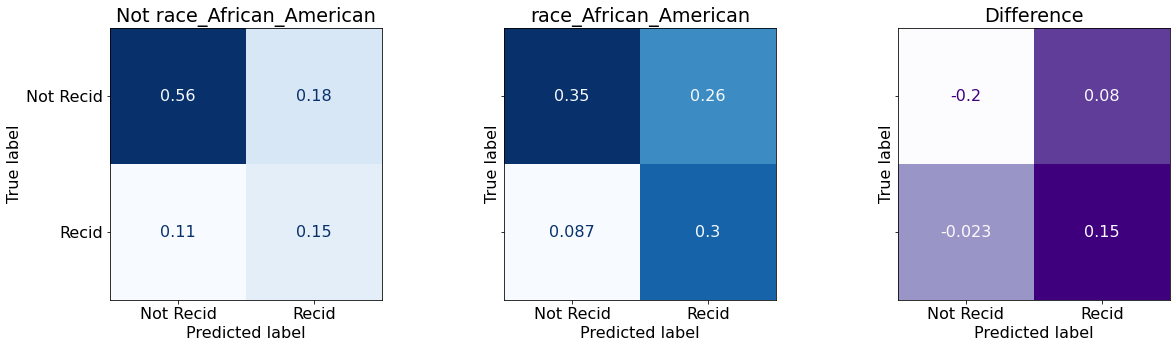

In [ ]:
show_confusion_matrix_diff("without_demographics", drop_cols)

In [ ]:
show_fairness_metrics("without_demographics", drop_cols)

/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy 
 recall 
 false positive rate 
 false negative rate 
 selection rate 
 
 
 is_recid 
 race_African_American 
 
 
 
 
 
 
 
 
 
 0 
 0 
 0.756522 
 0.0 
 0.243478 
 0.0 
 0.243478 
 
 
 1 
 0.576471 
 0.0 
 0.423529 
 0.0 
 0.423529 
 
 
 1 
 0 
 0.581882 
 0.581882 
 0.0 
 0.418118 
 0.581882 
 
 
 1 
 0.774942 
 0.774942 
 0.0 
 0.225058 
 0.774942

Better, but only barely. The differences are only slightly smaller -- about a 20% and 18% difference in recall and FPR, 8% and 15% difference in rate of being classified as recidivist.
What happened? The model now is not using any demographic information, yet the result was in several senses still unfair to the African-American group.

### Explaining Effect of Race on Prediction

Model explanations can help here, using a common tool like SHAP. Revisit the first model, and explain how much the demographic features actually influenced the output directly. SHAP attempts to isolate the effect of individual features on each prediction, and so can break down predictions by input, including here sensitive features like gender and race.

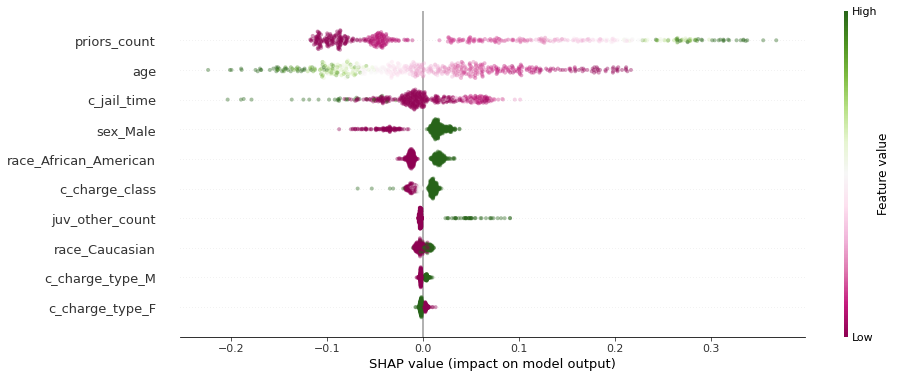

In [ ]:
from shap import TreeExplainer, summary_plot
import mlflow

def draw_summary_plot(data_experiment_tag, drop_cols=[]):
    run_id = find_best_run_id(data_experiment_tag)
    model = mlflow.xgboost.load_model(f"runs:/{run_id}/model")
  
    train_sample = X_train.drop(drop_cols, axis=1)
    example_samples = np.random.choice(np.arange(len(X_val)), 500, replace=False)
    example = X_val.drop(drop_cols, axis=1).iloc[example_samples]
  
    explainer = TreeExplainer(model, train_sample, model_output="probability")
    shap_values = explainer.shap_values(example, y=y_val.iloc[example_samples])
    summary_plot(shap_values, example, max_display=10, alpha=0.4, cmap="PiYG", plot_size=(14,6))

draw_summary_plot("with_demographics")

This explanation suggests, for example, that `priors_count` (number of prior arrests) is the most important feature. When high (green), it tends to contribute +20-30% to the predicted probabability of recidivism. A few lines down, we see that identify as male usually produces a +1-3% increase (or if not male: 1-7% decrease). And finally, indeed, `race_African_American` is an important feature, adding 1-2% to the classifier's result when true (as does, interestingly, `race_Caucasian`, though less so).

The direct effects -- SHAP suggests -- were small to begin with. Removing these inputs didn't change the result much. How then were the results so different for African-American defendants?

### A Word about Interpretation

Numbers and statistics are hard to reason about even in simple cases. This particular case touches on sensitive societal issues, as well. It can be tempting to infer things that the analysis do not directly suggest.

It's important to note that any analysis based on a model can only be as good as the model is. Here we know the model is not perfect, not even necessarily very accurate, as we may find in real-world models. SHAP does an admirable job of isolating features' effects from one another, but cannot be perfect.

Data isn't perfect either. It could have errors or misrepresent reality. Data can encode bias from the real world. Remember in particular that this data set does not tell us whether the defendant committed another crime; it tells us whether they were _arrested_ again. The model is, in effect, predicting something about recidivism but also about how and when people are arrested and charged, which are not the same thing.

In [ ]:
display(spark.read.table("user.compas").groupBy("race_African_American").avg('is_recid'))

race_African_American,avg(is_recid)
1,0.39475600873998545
0,0.27435711698659904


This is part of why it's not obvious in every case what "fair" should mean. In the second model, the base rate of recidivism _is_ higher for African-American defendants. It could be reasonable to say different classifier results are therefore expected. This does _not_ require believing that race _causes_ recidivism. On the contrary it's far more plausible to believe that both correlate with factors not present in the input, like socio-economic status. Even if race had 0 direct effect on the model output, is that fair?

## 3. Prioritize Equalized Odds with Microsoft Fairlearn

Instead, another approach is to try to equalize the metrics of interest directly. This asserts that a discrepancy, whatever its cause, is not desirable. This will come at some price; the model can't optimize for both parity in metrics and overall accuracy at the same time. The tradeoff may be well worthwhile though.

Microsoft's Fairlearn library has tools for analyzing parity metrics (already used above) but also mitigating parity differences. Some involve "preprocessing" of a model, which changes how the model is trained and optimized. Some simpler solutions involve "postprocessing", or modifying the model predictions after the fact. This is explored below.

In the case of a binary classifier which outputs probabilities, one must choose a threshold between probabilities that result in a positive and negative classification. For example, sometimes all predictions >= 0.5 probability are 'positive', but the threshold can be chosen to trade off precision and recall. The threshold can _also_ be chosen differently for different inputs, and that is the strategy that Fairlearn implements.

Below, Fairlearn's [ThresholdOptimizer](https://fairlearn.org/main/auto_examples/plot_credit_loan_decisions.html?highlight=threshold#postprocessing-mitigations-thresholdoptimizer) is injected into the same training process. It will try to achieve parity of equalized odds for African-American defendants versus others, while trying to maintain accuracy in this case. The resulting model can still be logged and served with MLflow with a simple wrapper to accomodate this special implementation:

In [ ]:
from fairlearn.postprocessing import ThresholdOptimizer
import mlflow.pyfunc

class FairlearnThresholdWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, threshold_optimizer, sensitive_cols):
        self.threshold_optimizer = threshold_optimizer
        self.sensitive_cols = sensitive_cols
      
    def predict(self, context, data):
        return self.threshold_optimizer.predict(data.drop(self.sensitive_cols, axis=1), \
                                            sensitive_features=data[self.sensitive_cols], random_state=42)

def predict_xgboost_fairlearn(X_train_xgb, y_train_xgb, X_val_xgb, y_val_xgb, params):
    mlflow.xgboost.autolog(disable=True)
    pos_weight = (len(y_train_xgb) / y_train_xgb.sum()) - 1
    # Can't use early stopping
    model = XGBClassifier(use_label_encoder=False, n_jobs=4, n_estimators=200, random_state=0, scale_pos_weight=pos_weight,
                          max_depth=int(params['max_depth']), learning_rate=params['learning_rate'], 
                          min_child_weight=params['min_child_weight'], 
                          subsample=params['subsample'], colsample_bytree=params['colsample_bytree'])
    # Wrap in an optimizer that prioritizes equalized odds while trying to maintain accuracy
    optimizer = ThresholdOptimizer(estimator=model, constraints="equalized_odds", objective="accuracy_score", predict_method="predict_proba")
    sensitive_cols = ["race_African_American"]
    optimizer.fit(X_train_xgb.drop(sensitive_cols, axis=1), y_train_xgb, sensitive_features=X_train_xgb[sensitive_cols])
    wrapper = FairlearnThresholdWrapper(optimizer, sensitive_cols)
    mlflow.pyfunc.log_model("model", python_model=wrapper)
    return wrapper.predict(None, X_val_xgb)

In [ ]:
run_data_experiment("with_demographics_fairlearn", predict_fn=predict_xgboost_fairlearn)

Hyperopt with SparkTrials will automatically track trials in MLflow. To view the MLflow experiment associated with the notebook, click the 'Runs' icon in the notebook context bar on the upper right. There, you can view all runs.
To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.
100%|██████████| 128/128 [02:24<00:00,  1.13s/trial, best loss: -0.5144092219020172]
Total Trials: 128: 128 succeeded, 0 failed, 0 cancelled.


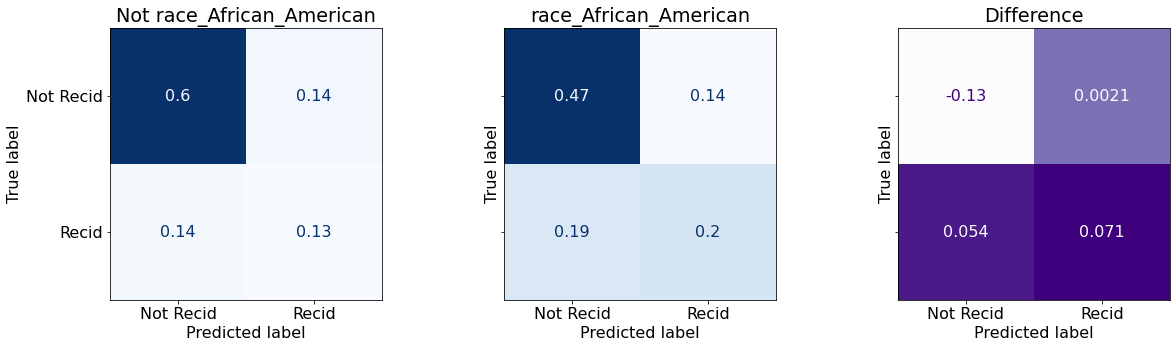

In [ ]:
show_confusion_matrix_diff("with_demographics_fairlearn")

In [ ]:
show_fairness_metrics("with_demographics_fairlearn")

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


accuracy 
 recall 
 false positive rate 
 false negative rate 
 selection rate 
 
 
 is_recid 
 race_African_American 
 
 
 
 
 
 
 
 
 
 0 
 0 
 0.808696 
 0.0 
 0.191304 
 0.0 
 0.191304 
 
 
 1 
 0.766176 
 0.0 
 0.233824 
 0.0 
 0.233824 
 
 
 1 
 0 
 0.480836 
 0.480836 
 0.0 
 0.519164 
 0.480836 
 
 
 1 
 0.508121 
 0.508121 
 0.0 
 0.491879 
 0.508121

## 4. Correct for "Bias" with SHAP Values

Earlier, SHAP was used to quantify the direct effect of features like race on the model's predicted probability. In theory this is a good estimate of the effect of race, in each prediction, independent of other inputs. While removing features like race from the input was a plausible way to make the results depend less on race, there's another take: use features like race, quantify their effects, _and back them out of the final prediction_. That is, if demographic factors explained a +3% effect on the resulting prediction, simply subtract 3% from the prediction instead.

This seems better than simply being blind to sensitive features, as their effects can influence a model through other inputs. It tries to surgically remove the detected effect of sensitive features, according to the model. However this approach does not attempt to equalize outcomes, parity metrics, at all, even if it might improve them. (See the [SHAP docs on fairness](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/Explaining%20quantitative%20measures%20of%20fairness.html#How-introducing-a-protected-feature-can-help-distinguish-between-label-bias-and-feature-bias) for more discussion.)

This too can be achieved by wrapping up a model and its SHAP explainer in a small custom model:

In [ ]:
import mlflow
from mlflow.pyfunc import PythonModel
from mlflow.models.signature import infer_signature
import pandas as pd
from shap import TreeExplainer

class SHAPCorrectedXGBoostModel(PythonModel):
  
    def __init__(self, booster, explainer, model_columns):
        self.booster = booster
        self.explainer = explainer
        self.sum_shap_indices = [model_columns.tolist().index(c) for c in model_columns if c.startswith("sex") or c.startswith("race")]

    def predict(self, context, model_input):
        predicted_probs = self.booster.predict_proba(model_input)[:,1]
        shap_values = self.explainer.shap_values(model_input)
        corrected_probs = predicted_probs - shap_values[:,self.sum_shap_indices].sum(axis=1)
        return pd.DataFrame((corrected_probs >= 0.5).astype('int32'))


with mlflow.start_run():
    mlflow.set_tag("data_experiment", "with_demographics_shap")
    run_id = find_best_run_id("with_demographics")
    booster = mlflow.xgboost.load_model(f"runs:/{run_id}/model")
    explainer = TreeExplainer(booster, X_train, model_output="probability")
    mlflow.pyfunc.log_model("model", python_model=SHAPCorrectedXGBoostModel(booster, explainer, X_train.columns),
                            input_example=X_val.head(5),
                            signature=infer_signature(X_val.head(20), pd.DataFrame([0] * 20, columns=["prediction"]))) # dummy for type inference

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (trai

 97%|=================== | 2143/2203 [00:19<00:00]       

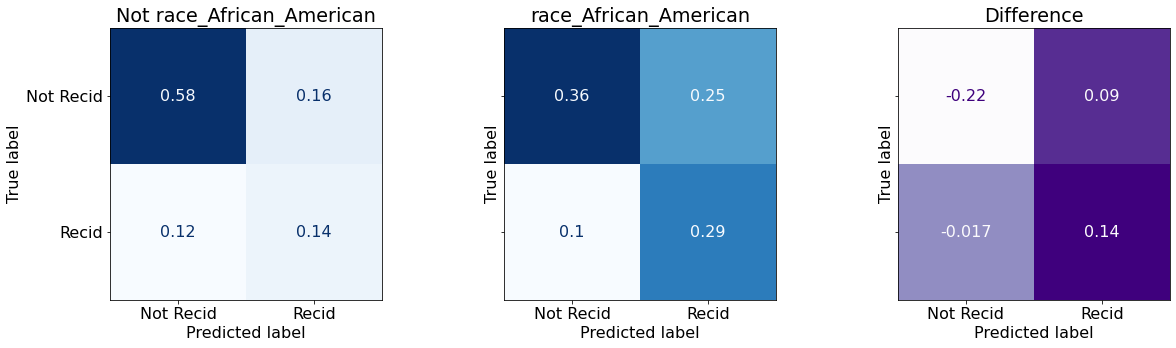

In [ ]:
show_confusion_matrix_diff("with_demographics_shap")

In [ ]:
show_fairness_metrics("with_demographics_shap")

 95%|=================== | 2096/2203 [00:18<00:00]       Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


accuracy 
 recall 
 false positive rate 
 false negative rate 
 selection rate 
 
 
 is_recid 
 race_African_American 
 
 
 
 
 
 
 
 
 
 0 
 0 
 0.783851 
 0.0 
 0.216149 
 0.0 
 0.216149 
 
 
 1 
 0.592647 
 0.0 
 0.407353 
 0.0 
 0.407353 
 
 
 1 
 0 
 0.547038 
 0.547038 
 0.0 
 0.452962 
 0.547038 
 
 
 1 
 0.737819 
 0.737819 
 0.0 
 0.262181 
 0.737819

The results in this case are somewhere in between the last two experiments -- no demographic information, and Fairlearn post-processing. This approach does not achieve equalized odds, though the parity gap is a few percentage points smaller. Accuracy stays higher compared to the Fairlearn approach however.

We can query the MLFlow data and plot it like other data, to more clearly summarize the differences in FPR/FNR across the four models:

In [ ]:
display(
  spark.read.format("mlflow-experiment").load("909eb80898e946bab8fed8938af419c0").\
     filter(col("metrics.`Af-Am FPR`") > 0).\
     orderBy("start_time").\
     select("tags.data_experiment", "metrics.`Not Af-Am FPR`", "metrics.`Af-Am FPR`", "metrics.`Not Af-Am FNR`", "metrics.`Af-Am FNR`")
)

data_experiment,Not Af-Am FPR,Af-Am FPR,Not Af-Am FNR,Af-Am FNR
with_demographics,0.21366459627329193,0.4411764705882353,0.46689895470383275,0.20185614849187936
without_demographics,0.24347826086956523,0.4235294117647059,0.4181184668989547,0.22505800464037123
with_demographics_fairlearn,0.19130434782608696,0.2338235294117647,0.519163763066202,0.4918793503480278
with_demographics_shap,0.21614906832298136,0.4073529411764706,0.4529616724738676,0.26218097447795824


## Conclusion

Detecting bias when using ML for predictive analytics is important. Mitigating bias is important too! There are differing definitions of 'fair', and it's important to understand which of them is the goal when trying to remediate bias in the world or data at the modeling step. Standard open source tools like SHAP and Fairlearn can be used easily to implement these strategies for existing modeling processes.